# Оптимизация тяговременных и массовых характеристик ЛА методом дифференциальной эволюции

In [1]:
from rocketlib import Rocket, throw_foo
import rocketlib
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import differential_evolution
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 14})

Расчетная схема: 
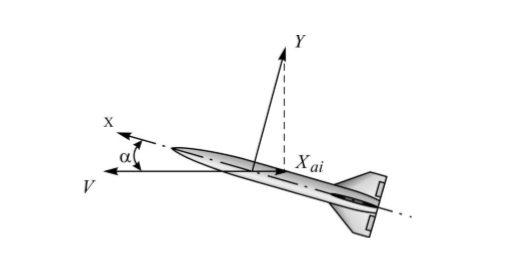

Для ракеты с параметрами, представленными ниже, с сформированной функцией управления ЛА, необходимо оптимизировать тяговременные и массовые характеристики ЛА для достижения максимальной дальности полета. ЛА представляет собой материальную точку, движущееся в вертикальной плоскости. На ЛА действуют:

1) Сила тяжести, направленная вертикально вниз. Ускорение свободного падения считается постоянным.

2) Сила тяги двигателя. Двигатель представляет собой двухрежимную установку. 

3) Аэродинамические силы, такие как лобовое сопротивление и подъемная сила. Силы зависят от скорости и от угла атаки ЛА, а также от плотности воздуха. Плотность воздуха уменьшается с высотой.

```python
    P_MAX = 5000    # максимальная тяга, Н
    OMEGA_SUM_MAX = # максимальная суммарная масса топлива, кг
    ALPHA_MAX = 10  # максимальный угол атаки, град
    VEL_0 = 30      # начальная скорость
    I_1 = 2100      # удельный импульс топлива, м/с
    MASS_GOOD = 40  # масса полезной нагрузки, кг
    BETA = 1.3      # коэффициент массового совершенства двигательной установки
    D = 100e-3      # калибр, м
```

Задача оптимизации состоит в перераспределении массы топлива первого и второго режима, а также регулировки уровеня тяги на этих режимах. Суммарная масса топлива не может быть больше некоторого значения. Таким образом, задача найти оптимальный вектор параметров

| ${θ_0}$  | ${P_1}$ | ${P_2}$  | ${ω_1}$  | ${ω_2}$  |
| :-: | :-: | :-: | :-: | :-: |

Где ${θ_0}$- начальный угол тангажа (бросания),

${P_1}$,${P_2}$- тяга на первом и втором режиме ДУ,

${ω_1}$,${ω_2}$- масса топлива на первом и втором режиме ДУ.

Таблица 1. Параметры летательного аппарата

| ${P_{max}}$, Н  | ${ω_{∑max}}$, кг | ${α_{max}}$, град | ${v_{0}}$, м/с |${I_{1}}$, м/с|${m_{пол}}$, кг|${β}$| ${D}$, м
| :-------------- | :--------------- | :-----------------| :------------- | :----------- | :------------ | :- | :------- |
| 5000 | 30 | 10 | 30 | 2100 | 40 | 1.3 | 100e-3 |



Где ${P_{max}}$ - максимальная тяга, ${ω_{∑max}}$ - максимальная суммарная масса топлива,

${α_{max}}$ - максимальный угол атаки, ${v_{0}}$ - начальная скорость ЛА,

${I_{1}}$ - удельный импульс топлива, ${m_{пол}}$ - масса полезной нагрузки,

${β}$ - коэффициент массового совершенства двигательной установки, ${D}$ - калибр ЛА.


## Система уравнений внешней баллистики

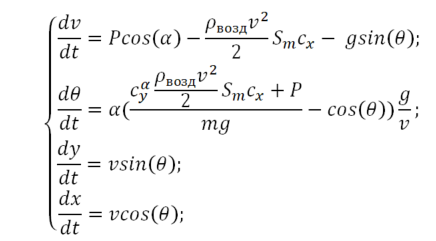

In [2]:
def my_alpha_foo(t, v, x, y, theta, P, m, rho, M, Cya, Cx0, Sm):
    if P!=0:
        return 8
    elif v<300 and t>30:
        return -3
    elif v>300 and v<400 and t>30:
        return -2
    elif v>400 and t>30:
        return 5
    elif v>250 and t>30:
        return 3
    else:
        return 0

In [3]:
# вектора минимальных и максимальных значений
mins = np.array([10, 100, 100, 0.1])
maxes= np.array([75, Rocket.P_MAX, Rocket.P_MAX, 0.9])

def denormalize(x):
    return mins + x*(maxes-mins)

def normalize(x):
    return (x - mins) / (maxes-mins)

history = []
theta_hist = []
P1_hist = []
P2_hist = []
omega1_hist = []
omega2_hist = []

def minimize_foo(x):
    point = denormalize(x)
    theta, P1, P2, om_port = point
    opts = {
        'theta': theta,
        'P1': P1,
        'P2': P2,
        'omega1': Rocket.OMEGA_SUM_MAX * om_port,
        'omega2': Rocket.OMEGA_SUM_MAX - Rocket.OMEGA_SUM_MAX * om_port
    }
    res = throw_foo(opts, my_alpha_foo) 
    crit = res['x'][-1]
    history.append((crit, point))
    theta_hist.append((opts['theta'],point))
    P1_hist.append((opts['P1'],point))
    P2_hist.append((opts['P2'],point))
    omega1_hist.append((opts['omega1'],point))
    omega2_hist.append((opts['omega2'],point))
    return -crit

bounds = [(0,1),(0,1),(0,1),(0,1)]

In [4]:
# время расчета 7-9 минут i7 1165 16 RAM
result = differential_evolution(minimize_foo, bounds)

In [5]:
result

     fun: -79456.72420886687
 message: 'Optimization terminated successfully.'
    nfev: 3545
     nit: 47
 success: True
       x: array([0.09154542, 0.52889652, 0.00376951, 0.29975188])

Графики для кажого поколения

In [7]:
generation_count = np.linspace(1,len(history),len(history))

In [8]:
df = pd.DataFrame({
    
    'generation':generation_count,
    'criterion':[i for i,j in history],
    'thetta':[i for i,j in theta_hist],
    'p1':[i for i,j in P1_hist],
    'p2':[i for i,j in P2_hist],
    'omega1':[i for i,j in omega1_hist],
    'omega2':[i for i,j in omega2_hist]  
    
})
df

,generation,criterion,thetta,p1,p2,omega1,omega2
0,1.0,408.776341,63.113934,2834.884368,3781.936766,26.594488,3.405512
1,2.0,3707.035513,32.422583,3924.267816,422.912450,23.976568,6.023432
2,3.0,4412.369371,46.367452,2148.923839,4270.762987,25.888868,4.111132
3,4.0,203.579171,35.390093,584.357828,4228.382267,17.035328,12.964672
4,5.0,127.837885,74.776440,1465.942832,1037.525717,9.124741,20.875259
...,...,...,...,...,...,...,...
3540,3541.0,79460.533158,15.948798,2692.234764,118.493893,10.192045,19.807955
3541,3542.0,79460.533130,15.948798,2692.234764,118.493893,10.192045,19.807955
3542,3543.0,79460.533270,15.948798,2692.234813,118.493893,10.192045,19.807955
3543,3544.0,79460.538951,15.948798,2692.234764,118.493942,10.192045,19.807955


In [9]:
df.to_csv('data.csv', index=False)

In [10]:
df = pd.read_csv('data.csv')

Количество поколений

In [24]:
df.shape[0]

3545

Text(0, 0.5, '$x_m$, км')

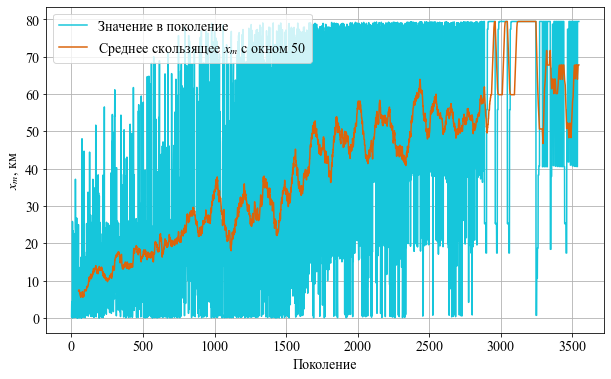

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.criterion/10**3, color='#16C6DB', label='Значение в поколение')
plt.plot(df.generation,df.criterion.rolling(50).mean()/10**3, color='#DB640B', label=r'Среднее скользящее $x_m$ с окном 50')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Поколение')
plt.ylabel('$x_m$, км')

Text(0, 0.5, '$\\theta$, град')

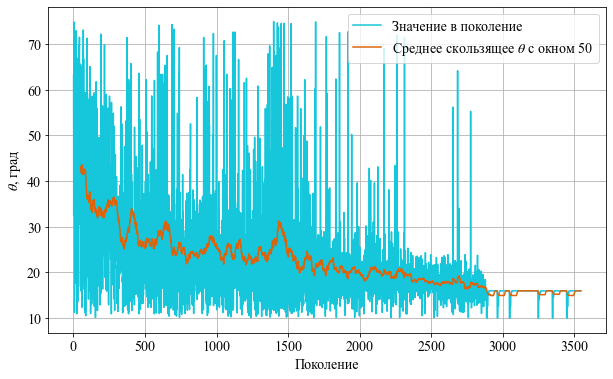

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.thetta, color='#16C6DB', label='Значение в поколение')
plt.plot(df.generation,df.thetta.rolling(50).mean(), color='#DB640B', label=r'Среднее скользящее $\theta$ с окном 50')
plt.legend()
plt.grid()
plt.xlabel('Поколение')
plt.ylabel(r'$\theta$, град')

Text(0, 0.5, '$P_1$, Н')

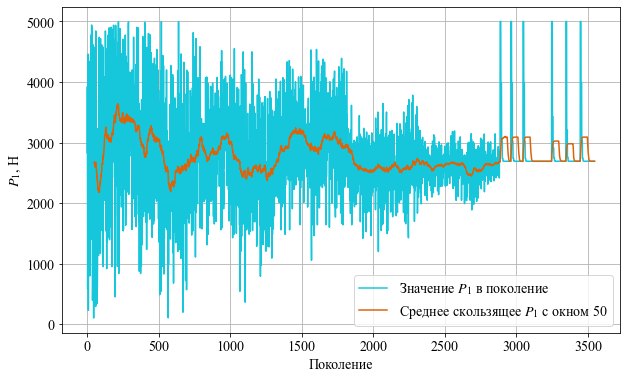

In [13]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.p1, color='#16C6DB',label='Значение $P_1$ в поколение')
plt.plot(df.generation,df.p1.rolling(50).mean(), color='#DB640B', label='Среднее скользящее $P_1$ с окном 50')
plt.legend()
plt.grid()
plt.xlabel('Поколение')
plt.ylabel('$P_1$, Н')

Text(0, 0.5, '$P_2$, Н')

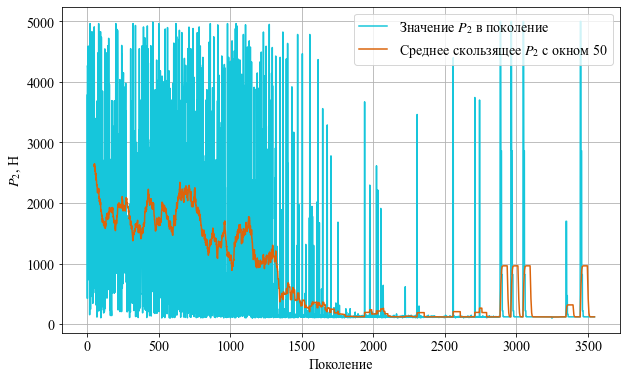

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.p2, color='#16C6DB',label='Значение $P_2$ в поколение')
plt.plot(df.generation,df.p2.rolling(50).mean(), color='#DB640B', label='Среднее скользящее $P_2$ с окном 50')
plt.legend()
plt.grid()
plt.xlabel('Поколение')
plt.ylabel('$P_2$, Н')

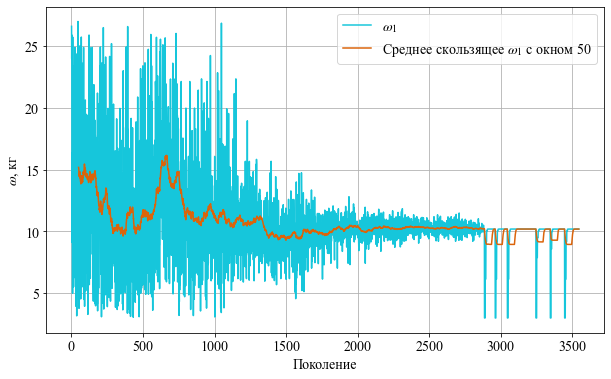

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.omega1, color='#16C6DB',label=r'$\omega_1$')
plt.plot(df.generation,df.omega1.rolling(50).mean(), color='#DB640B', label=r'Среднее скользящее $\omega_1$ с окном 50')
plt.legend()
plt.grid()
plt.xlabel('Поколение')
plt.ylabel(r'$\omega$, кг')
plt.legend()

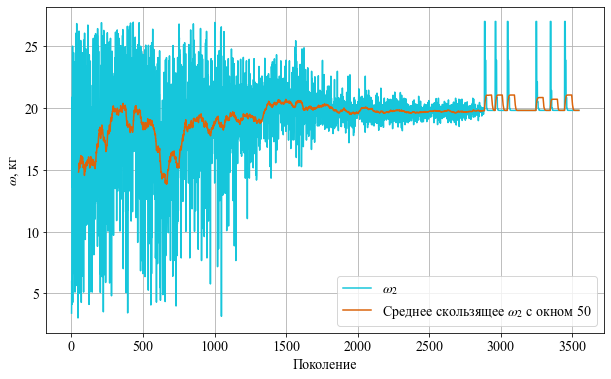

In [16]:
plt.figure(figsize=(10,6))
plt.plot(df.generation,df.omega2, color='#16C6DB',label=r'$\omega_2$')
plt.plot(df.generation,df.omega2.rolling(50).mean(), color='#DB640B', label=r'Среднее скользящее $\omega_2$ с окном 50')
plt.legend()
plt.grid()
plt.xlabel('Поколение')
plt.ylabel(r'$\omega$, кг')
plt.legend()

In [17]:
point = denormalize(result.x)
theta, P1, P2, om_port = point
opts = {
    'theta': theta,
    'P1': P1,
    'P2': P2,
    'omega1': Rocket.OMEGA_SUM_MAX * om_port,
    'omega2': Rocket.OMEGA_SUM_MAX - Rocket.OMEGA_SUM_MAX * om_port
}
res = throw_foo(opts, my_alpha_foo) 

Траектория ла

Text(0, 0.5, '$y$,м')

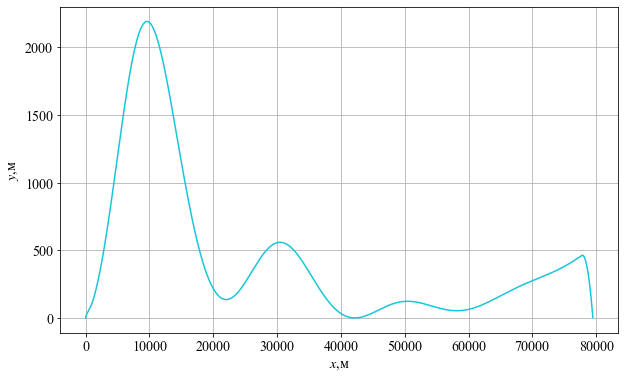

In [18]:
plt.figure(figsize=(10,6))
plt.plot(res['x'], res['y'], color='#16C6DB')
plt.grid()
plt.xlabel('$x$,м')
plt.ylabel('$y$,м')

Скорость от времени

Text(0, 0.5, '$v$, м/с')

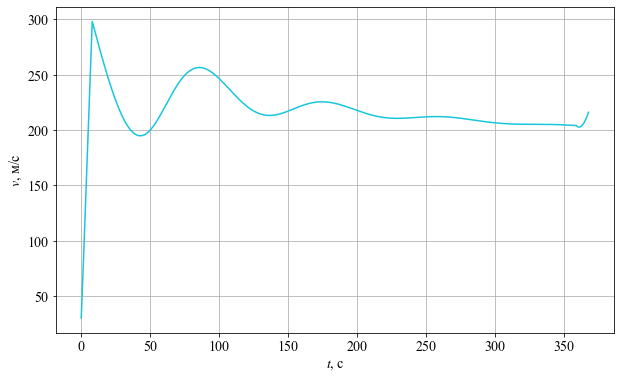

In [19]:
plt.figure(figsize=(10,6))
plt.plot(res['t'], res['v'], color='#16C6DB')
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('$v$, м/с')

График тяги от времени

In [20]:
opts

{'theta': 15.950452086856796,
 'P1': 2691.59294874574,
 'P2': 118.4705806149837,
 'omega1': 10.194045222403748,
 'omega2': 19.805954777596252}

In [21]:
r = Rocket(opts, my_alpha_foo)

Text(0, 0.5, '$P$, Н')

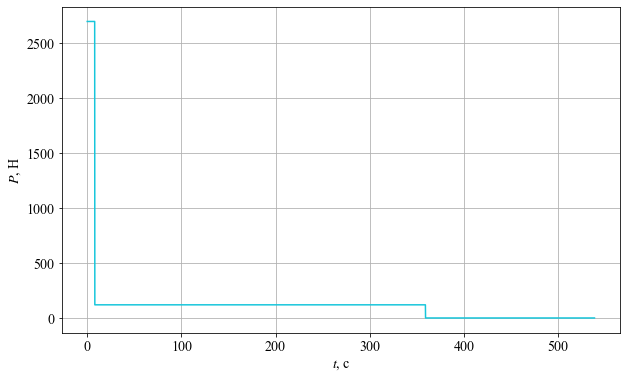

In [22]:
ts = np.linspace(0,1.5*(r.t1+r.t2),10000)
plt.figure(figsize=(10,6))
plt.plot(ts, r.get_P(ts), color='#16C6DB')
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('$P$, Н')